# Schrödinger's equaiton


In [9]:
import numpy as np

L = 20.0
N = 1024

x = np.linspace(-L, L, N, endpoint=False)
dx = x[1] - x[0]

k = (2 * np.pi) * np.fft.fftfreq(N, d=dx)

In [10]:
x0 = -5.0
sig = 0.5
k0 = 5.0


psi0 = np.exp(-(x - x0)**2 / (2 * sig**2)) * np.exp(1j * k0 * x)

## For V as a square barrier 

 * The particle is free outside, V = 0

 * Inside constant, positive V that is not 0 and not infinite

 * This allows the particle to reclect off the barrier or trasnmit


In [11]:
V0 = 10.0
V = np.zeros_like(x) #Set potential equal to 0 everywhere(array)
V[(x > -1) & (x < 1)] = V0 #Set potential to equal 10 from -1 to 1



In [12]:
hbar = 1.0
m = 1.0
#I have these set to 1 for now to simplify the code.  Real values can be added later if necesary

T = (hbar**2 * k**2) / (2 * m)
#Kinetic energy, Fourier Space

expT = np.exp(-1j * T * (dx/2) / hbar)   # half step
expV = lambda dt: np.exp(-1j * V * dt / hbar)  # potential step

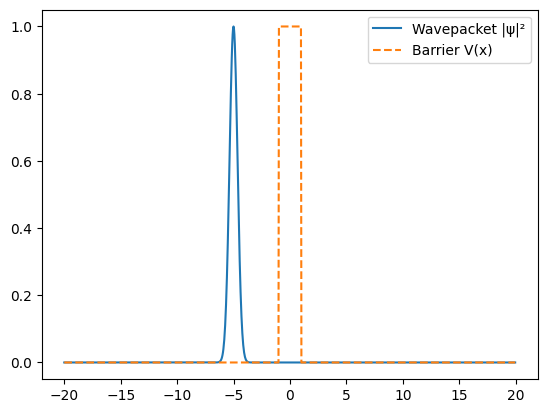

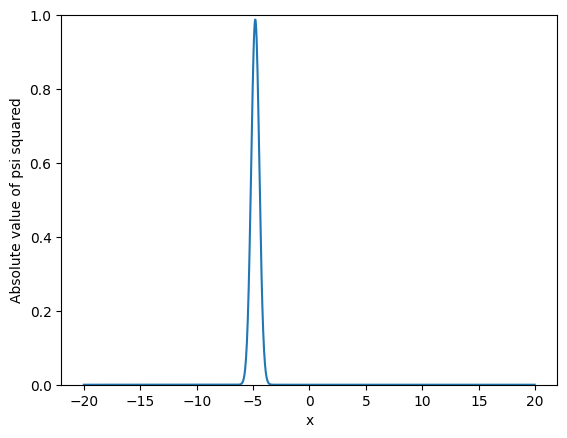

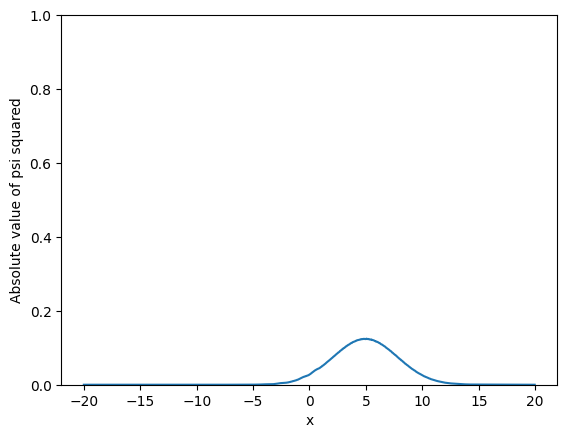

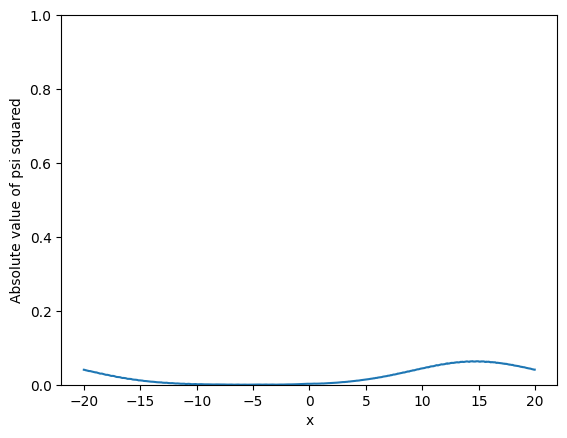

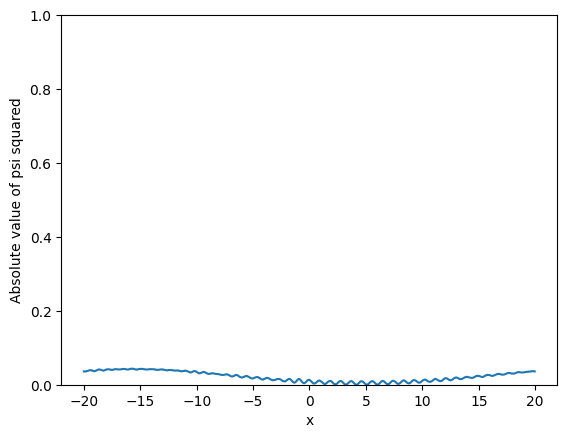

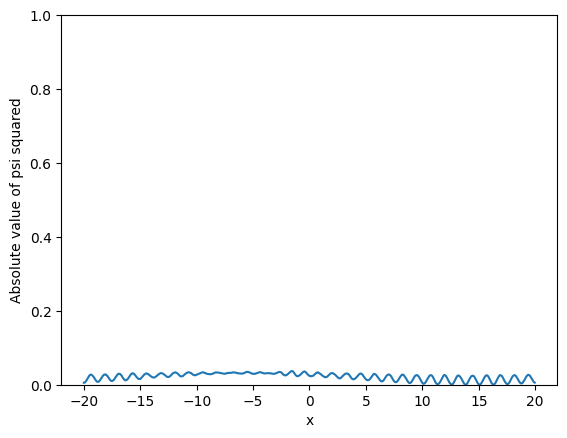

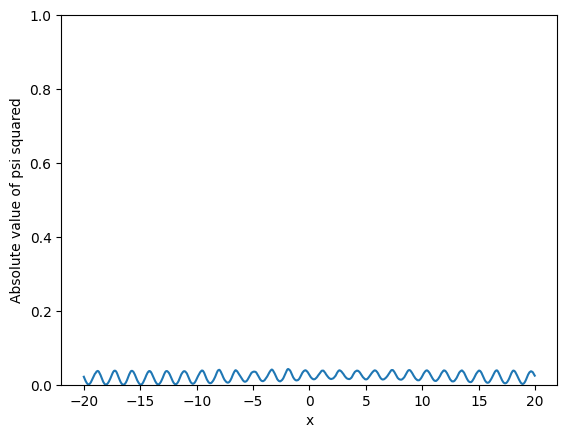

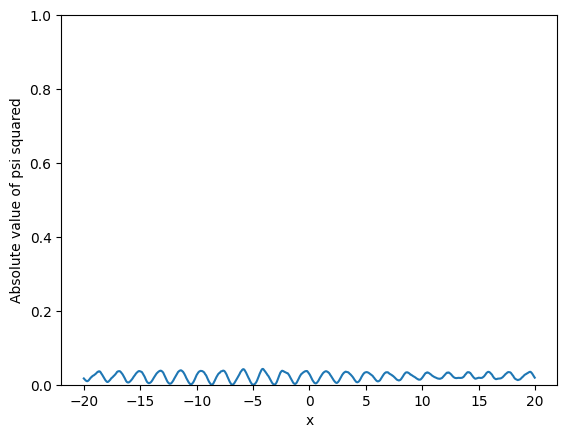

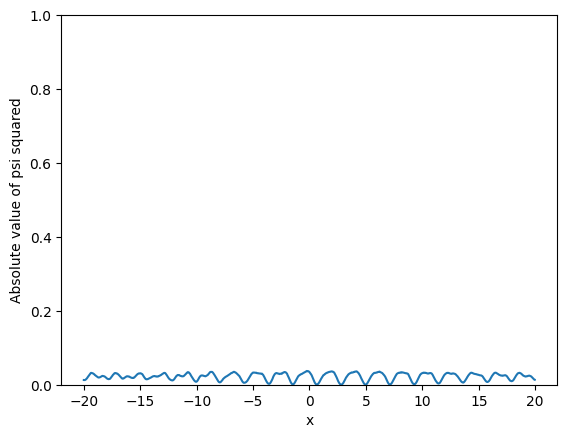

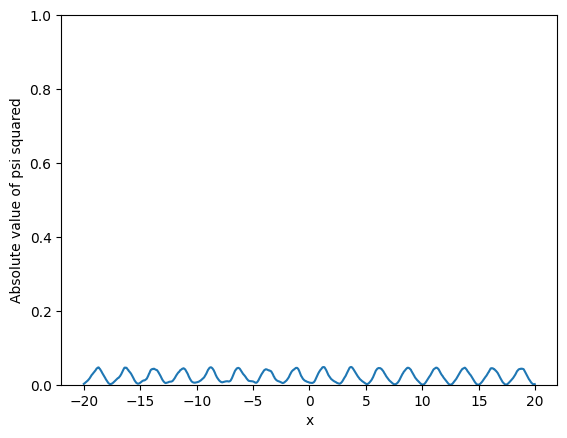

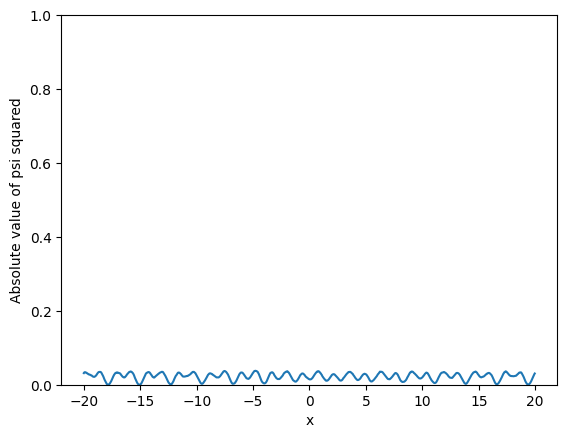

<Figure size 640x480 with 0 Axes>

In [14]:
from matplotlib import pyplot as plt

dt = 0.001
steps = 500

psi = psi0.copy()

plt.plot(x, np.abs(psi)**2, label="Wavepacket |ψ|²")
plt.plot(x, V / np.max(V) * np.max(np.abs(psi)**2), label="Barrier V(x)", linestyle="--")  # scaled barrier for visibility
plt.legend()
plt.show()


for i in range(steps):
    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    psi = expV(dt) * psi

    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    if i % 50 == 0:
        plt.xlabel("x"); plt.ylabel("Absolute value of psi squared")
        
        plt.plot(x, np.abs(psi)**2)
        plt.ylim(0, 1)
        plt.pause(0.01)
        plt.clf()
        

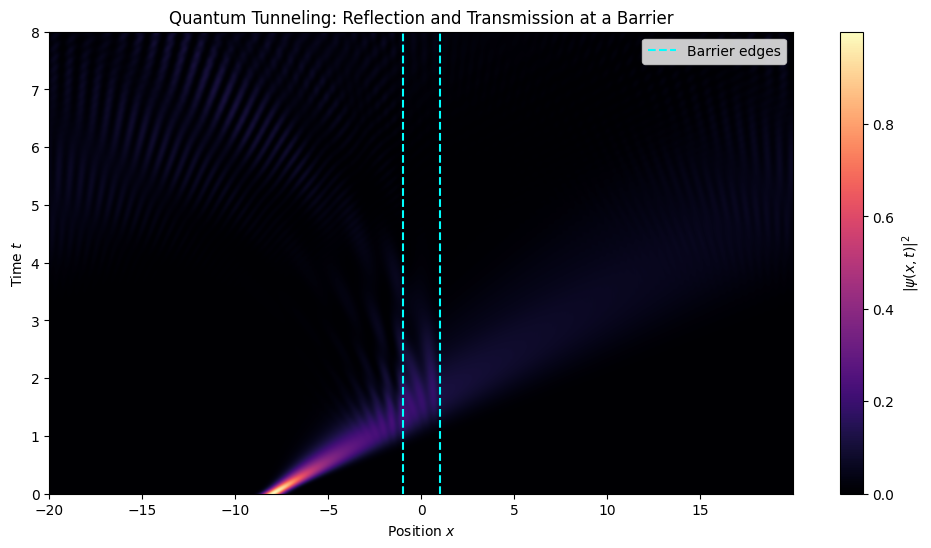

In [33]:
# Grid setup
L = 20.0
N = 2048
x = np.linspace(-L, L, N, endpoint=False)
dx = x[1] - x[0]
k = (2 * np.pi) * np.fft.fftfreq(N, d=dx)

# Barrier potential setup
V0 = 5.0            # Barrier height
a, b = -1, 1        # Barrier from x=a to x=b
V = np.zeros_like(x)
V[(x > a) & (x < b)] = V0

# Initial wavepacket
x0 = -8.0           # Start far left
sigma = 0.5         # Moderate width
k0 = 5.0            # Initial momentum
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)

# Time stepping
dt = 0.001
steps = 8000

# Evolution operators
T = 0.5 * k**2
expT = np.exp(-1j * T * dt / 2)
expV = np.exp(-1j * V * dt)

# Storage for |psi|^2 snapshots
snapshots = []

for i in range(steps):
    # Half-step kinetic evolution (Fourier space)
    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    # Full-step potential evolution (real space)
    psi = expV * psi

    # Half-step kinetic evolution again
    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    # Save every 10th frame
    if i % 10 == 0:
        snapshots.append(np.abs(psi)**2)

# Convert snapshots to array
snapshots = np.array(snapshots)
time_axis = np.linspace(0, dt * steps, len(snapshots))

# Plot contour
plt.figure(figsize=(12, 6))
extent = [x[0], x[-1], time_axis[0], time_axis[-1]]
plt.imshow(snapshots, extent=extent, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label=r'$|\psi(x,t)|^2$')
plt.xlabel('Position $x$')
plt.ylabel('Time $t$')
plt.title('Quantum Tunneling: Reflection and Transmission at a Barrier')

# Overlay barrier location for visual clarity
plt.axvline(x=a, color='cyan', linestyle='--', label="Barrier edges")
plt.axvline(x=b, color='cyan', linestyle='--')
plt.legend()
plt.show()

## Solving the 2D Hydrogen Atom with Spectral Methods

In the following section, we use spectral methods to solve the 2-dimensional Schrodinger's equation for a hydrogen atom, and visualize the s, px, and py orbitals. We use fast fourier transform to compute the Laplacian, and the eigsh function from scipy to numerically compute the first four lowest energy eigenvalue-eigenvector pairs for 

$$
H \psi \;=\; E \psi
$$

Finally, we plot $|\psi|^2$ as a colormap, which gives us the orbitals.

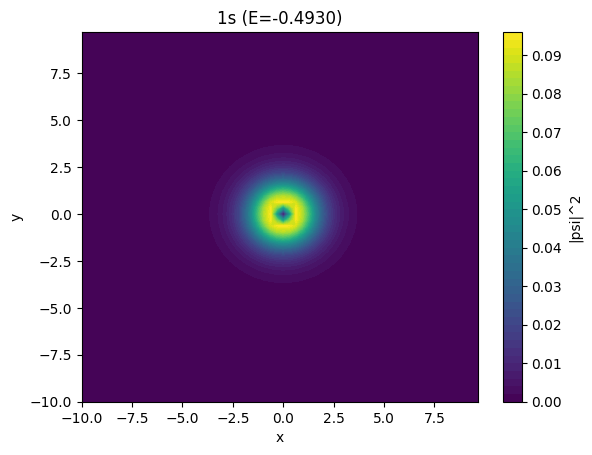

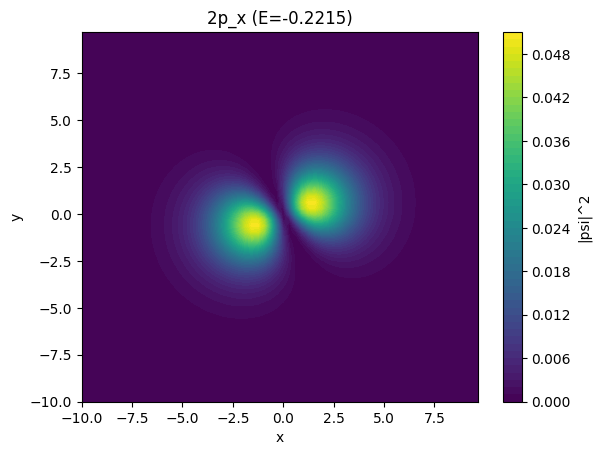

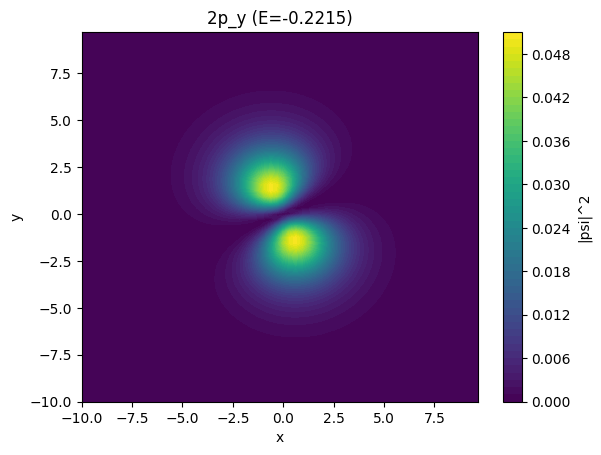

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftfreq
from scipy.sparse.linalg import eigsh, LinearOperator

# grid & potential
N = 64
L = 20.0
x = np.linspace(-L/2, L/2, N, endpoint=False)
dx = x[1] - x[0]
X, Y = np.meshgrid(x, x)
r = np.sqrt(X*X + Y*Y) + 1e-12 # adding tiny value to avoid singularity at r = 0
V = -1.0 / r

# spectral laplacian
kx = fftfreq(N, d=dx) * 2*np.pi
ky = fftfreq(N, d=dx) * 2*np.pi
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2

def lap(psi):
    return np.real(ifft2(-K2 * fft2(psi)))

def Hpsi(flat_psi):
    psi = flat_psi.reshape(N, N)
    return ( -0.5*lap(psi) + V*psi ).ravel()

H = LinearOperator((N*N, N*N), Hpsi)

evals, evecs = eigsh(H, k=4, sigma=-0.5) # finding E and psi for 1s, 2s, and the degenerate pair which gives 2px and 2py

# unpacking and normalizing orbitals
orbitals = []
for i in range(4):
    psi = evecs[:, i].reshape(N, N)
    norm = np.sqrt((np.abs(psi)**2).sum() * dx * dx)
    orbitals.append(psi / norm)

# plot 1s
s = orbitals[0]
plt.figure()
plt.contourf(X, Y, np.abs(s)**2, levels=50)
plt.title(f"1s (E={evals[0]:.4f})")
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar(label="|psi|^2")
plt.show()

px, py = orbitals[1], orbitals[2]

for psi, label in [(px, "2p_x"), (py, "2p_y")]:
    plt.figure()
    plt.contourf(X, Y, np.abs(psi)**2, levels=50)
    plt.title(f"{label} (E={evals[1]:.4f})")
    plt.xlabel("x"); plt.ylabel("y")
    plt.colorbar(label="|psi|^2")
    plt.show()


## Note about 1s orbital

In the plot, the 1s orbital seems to have a node at the origin, which doesn't make sense physically. This could be due to the fact that we define $r = \sqrt{x^2 + y^2} + 10^{-6}$. The reason we do this is to avoid division by 0 at the origin in V, but this could be interfering with the eigsh function and leading to the wrong wavefunction.